In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as sstat
from mpmath import mp
import math
import random
from scipy.stats import multivariate_normal

psd = pd.DataFrame
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

Generiamo 1000 sample da una normale:

\begin{equation*}
\begin{aligned}
    y_{obs} &\sim \mathcal{N}(\mu_{obs}, σ_{obs} ^2) \\
\end{aligned}
\end{equation*}

e scegliamo come modello:

\begin{equation*}
\begin{aligned}
    y_i | \mu &\sim ^{iid} \mathcal{N}(\mu, \sigma_{obs} ^2)  \\
    \mu & \sim \mathcal{N}(\mu_0, \sigma_0^2)
\end{aligned}
\end{equation*}

$\sigma_{obs}$ noto

$\mu_0, \sigma_0$ fissati

$\mathscr{L}(y_i|\mu)$:

In [43]:
def single_lik(mu,tau):
   return tfd.Normal(mu,np.sqrt(1/tau))

# $\pi(\mu)$:

In [44]:
def prior_mu():
    return tfd.Normal(mu0,1/tau0)

In [45]:
def prior_tau():
    return tfd.Gamma(c,d)

proposal distribution $g(\theta'|\theta)$= $N(\theta, 1)$

In [46]:
def proposal_mu(mu):
  return tfd.Normal(mu,1)

In [47]:
def proposal_tau(tau):
  return tfd.Gamma(tau*6,6)

definiamo la funzione Kernel Gaussiana

In [48]:
def my_kernel(u):
  return 1/(np.sqrt(2*math.pi))*np.exp(-1/2*u**2)

In [49]:
def K_h(u,h):
  return my_kernel(u/h)/h

Come summary statistics utilizziamo:


*   Quantili
*   Media campionaria



In [50]:
def S2(y):
  quantiles=[]
  for i in range(9):
      quantiles.append(np.quantile(y,0.1+0.1*i))         #quantili 0,1 0,2 0,3 0,4 0,5 0,6 0,7 0,8 0,9
  return quantiles

In [51]:
def S1(y):
  s_1 = np.mean(y)
  s_2 = np.var(y)
  return [s_1,s_2]

In [52]:
##MAXIMAL COUPLING FOR DATASET GENERATION
def maximal_coupling2(mu_x,tau_x,mu_y,tau_y):

      proposed_x = single_lik(mu_x,tau_x).sample()
      pX =  single_lik(mu_x,tau_x).prob(proposed_x)
      w = tfd.Uniform(0,1).sample()*pX
      qX = single_lik(mu_y,tau_y).prob(proposed_x)
      if w < qX:
          x_new = proposed_x
          y_new = proposed_x
      else:
          t = True
          while t == True:
                proposed_y = single_lik(mu_y,tau_y).sample()
                qY =  single_lik(mu_y,tau_y).prob(proposed_y) 
                w =  tfd.Uniform(0,1).sample()*qY
                pY = single_lik(mu_x,tau_x).prob(proposed_y)
                if w > pY :
                  t = False

          x_new = proposed_x
          y_new = proposed_y  
          
      return x_new,y_new

In [53]:
##MAXIMAL COUPLING OF MU
def maximal_coupling_mu(x,y):

      current_x = x
      current_y = y  
      proposed_x = current_x + tfd.Normal(0,1).sample()
      pX = sstat.norm.pdf(proposed_x,current_x,1)
      w = tfd.Uniform(0,1).sample()*pX
      qX = sstat.norm.pdf(proposed_x,current_y,1)
      if w < qX:
          x_new = proposed_x
          y_new = proposed_x
      else:
          t = True
          while t == True:
                proposed_y = current_y + tfd.Normal(0,1).sample()
                qY =  sstat.norm.pdf(proposed_y,current_y,1) 
                w =  tfd.Uniform(0,1).sample()*qY
                pY = sstat.norm.pdf(proposed_y,current_x,1)
                if w > pY :
                  t = False

          x_new = proposed_x
          y_new = proposed_y

      return x_new, y_new

In [54]:
##MAXIMAL COUPLING OF TAU
def maximal_coupling_tau(x,y):
      
      current_x = x
      current_y = y  
      proposed_x = proposal_tau(current_x).sample()
      pX = proposal_tau(current_x).prob(proposed_x)
      w = tfd.Uniform(0,1).sample()*pX
      qX = proposal_tau(current_y).prob(proposed_x)
      if w < qX:
          x_new = proposed_x
          y_new = proposed_x
      else:
          t = True
          while t == True:
                proposed_y = proposal_tau(current_x).sample()
                qY =  proposal_tau(current_y).prob(proposed_y) 
                w =  tfd.Uniform(0,1).sample()*qY
                pY = proposal_tau(current_x).prob(proposed_y)
                if w > pY :
                  t = False

          x_new = proposed_x
          y_new = proposed_y  

      return x_new, y_new

ABC algorithm:

In [55]:
def abc_algo (N, S, y_obs, h):
    
    s_obs = S(y_obs)
    theta_mu_x = []
    theta_tau_x = []
    theta_mu_y = []
    theta_tau_y = []
    datax_current = []
    datay_current = [] 
    theta_tau_x0 = prior_tau().sample()
    theta_tau_y0 = prior_tau().sample()
    theta_mu_x0 = prior_mu().sample()
    theta_mu_y0 = prior_mu().sample()

    for j in range (100):
                  newdata_x,newdata_y = maximal_coupling2(theta_mu_x0,theta_tau_x0,theta_mu_y0,theta_tau_y0)
                  datax_current.append(newdata_x)
                  datay_current.append(newdata_y)
    sx_0 = S(datax_current)
    sy_0 = S(datay_current)

    while K_h(np.linalg.norm(np.array(sx_0)-np.array(s_obs)),h)<=0:
        theta_tau_x0 = prior_tau().sample()
        theta_mu_x0 = prior_mu().sample()
        datax_0 = single_lik(theta_mu_x0,theta_tau_x0).sample(100) 
        sx_0 = S(datax_0)


    while K_h(np.linalg.norm(np.array(sy_0)-np.array(s_obs)),h)<=0:
        theta_tau_y0 = prior_tau().sample()
        theta_mu_y0 = prior_mu().sample()
        datay_0 = single_lik(theta_mu_y0,theta_tau_y0).sample(100) 
        sy_0 = S(datay_0)
      
    theta_mu_x.append(theta_mu_x0)
    theta_tau_x.append(theta_tau_x0)
    theta_mu_y.append(theta_mu_y0)
    theta_tau_y.append(theta_tau_y0)
   
    theta_muold_x = theta_mu_x0
    theta_tauold_x = theta_tau_x0
    theta_muold_y = theta_mu_y0
    theta_tauold_y = theta_tau_y0
    sx_old = sx_0
    sy_old = sy_0
    

    for i in range(N):
        theta_mucurrent_x,theta_mucurrent_y = maximal_coupling_mu(theta_muold_x,theta_muold_y)
        theta_taucurrent_x,theta_taucurrent_y = maximal_coupling_tau(theta_tauold_x,theta_tauold_y)

        datax_current = []
        datay_current = []

        for j in range (100):
                  [newdata_x,newdata_y] = maximal_coupling2(theta_mucurrent_x,theta_taucurrent_x,theta_mucurrent_y,theta_taucurrent_y)
                  datax_current.append(newdata_x)
                  datay_current.append(newdata_y)

        sx_current = S(datax_current)
        sy_current = S(datay_current) 
               
        xprob = min([1.,(K_h(np.linalg.norm(np.array(sx_current) - np.array(s_obs)),h)*prior_tau().prob(theta_taucurrent_x)*prior_mu().prob(theta_mucurrent_x)*proposal_tau(theta_tauold_x).prob(theta_taucurrent_x))/(
             K_h(np.linalg.norm(np.array(sx_old)-np.array(s_obs)),h)*(prior_tau().prob(theta_tauold_x)*prior_mu().prob(theta_muold_x))*proposal_tau(theta_taucurrent_x).prob(theta_tauold_x))])
        yprob = min([1.,(K_h(np.linalg.norm(np.array(sy_current) - np.array(s_obs)),h)*prior_tau().prob(theta_taucurrent_y)*prior_mu().prob(theta_mucurrent_y)*proposal_tau(theta_tauold_y).prob(theta_taucurrent_y))/(
             K_h(np.linalg.norm(np.array(sy_old)-np.array(s_obs)),h)*(prior_tau().prob(theta_tauold_y)*prior_mu().prob(theta_muold_y))*proposal_tau(theta_taucurrent_y).prob(theta_tauold_y))])
        
        u = tfd.Uniform(0,1).sample()

        if u < xprob:
              theta_mui_x = theta_mucurrent_x
              theta_taui_x = theta_taucurrent_x
              s_ix = sx_current
        else: 
              theta_mui_x = theta_muold_x
              theta_taui_x = theta_tauold_x
              s_ix = sx_old

        if u < yprob:
              theta_mui_y = theta_mucurrent_y
              theta_taui_y = theta_taucurrent_y
              s_iy = sy_current
        else: 
              theta_mui_y = theta_muold_y
              theta_taui_y = theta_tauold_y
              s_iy = sy_old
              

        theta_muold_x = theta_mui_x
        theta_tauold_x = theta_taui_x
        sx_old = s_ix

        theta_muold_y = theta_mui_y
        theta_tauold_y = theta_taui_y
        sy_old = s_iy
        
        theta_mu_x.append(theta_mui_x)
        theta_tau_x.append(theta_taui_x)
        theta_mu_y.append(theta_mui_y)
        theta_tau_y.append(theta_taui_y)
        
        
    return  theta_mu_x, theta_mu_y, theta_tau_x, theta_tau_y

testiamo con le seguenti variabili:

In [76]:
##VARIABILI:
c = 1
d = 1
mu0 = 34
tau0 = 0.3
k = 5
n = 100
mu_obs = 30
tau_obs = 0.5
y_obs = tfp.distributions.Normal(mu_obs,np.sqrt(1/tau_obs)).sample(100)

In [77]:
provamux, provamuy, provataux, provatauy = abc_algo (500, S2, y_obs, 0.5)   

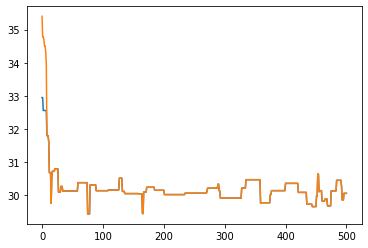

In [78]:
mu_coupled = []
for i in range(len(provamux)):
  mu_coupled.append([provamux[i],provamuy[i]])
plt.plot(mu_coupled)

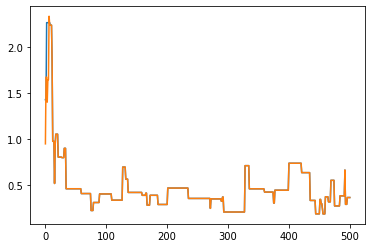

In [79]:
tau_coupled = []
for i in range(len(provataux)):
  tau_coupled.append([provataux[i],provatauy[i]])
plt.plot(tau_coupled)

(array([ 28., 102., 267.,  77.,  15.,   0.,   0.,   4.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   1.,   5.,   0.,   1.]),
 array([29.438963, 29.737179, 30.035395, 30.33361 , 30.631826, 30.930042,
        31.228258, 31.526474, 31.82469 , 32.122906, 32.42112 , 32.719337,
        33.01755 , 33.31577 , 33.613983, 33.9122  , 34.210415, 34.508633,
        34.806847, 35.105064, 35.40328 ], dtype=float32),
 <a list of 20 Patch objects>)

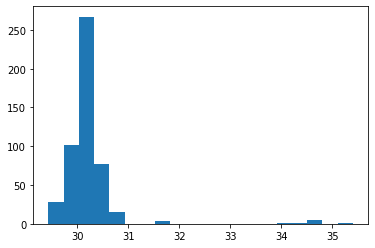

In [80]:
plt.hist(provamuy,bins=20)

(array([226., 194.,  58.,   7.,   4.,   2.,   0.,   1.,   0.,   9.]),
 array([0.18721641, 0.3954857 , 0.60375498, 0.81202427, 1.02029355,
        1.22856284, 1.43683212, 1.64510141, 1.8533707 , 2.06163998,
        2.26990927]),
 <a list of 10 Patch objects>)

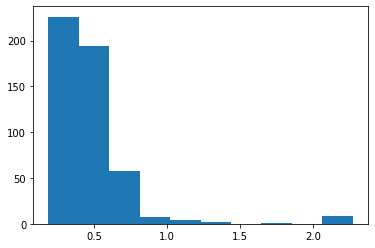

In [81]:
plt.hist(provataux)

In [82]:
np.mean(provamux)

30.180103

In [84]:
np.mean(provamuy)

30.211502

In [85]:
np.mean(provataux)

0.46739114935340836

In [86]:
np.mean(provatauy)

0.4616352950512614

controlliamo il risultato plottando la posterior corretta